In [130]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

mpl.rcParams['figure.figsize'] = (15.0, 6.0)

# Datasets Overview

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

In [131]:
# Read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Offers

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [132]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [133]:
portfolio.shape

(10, 6)

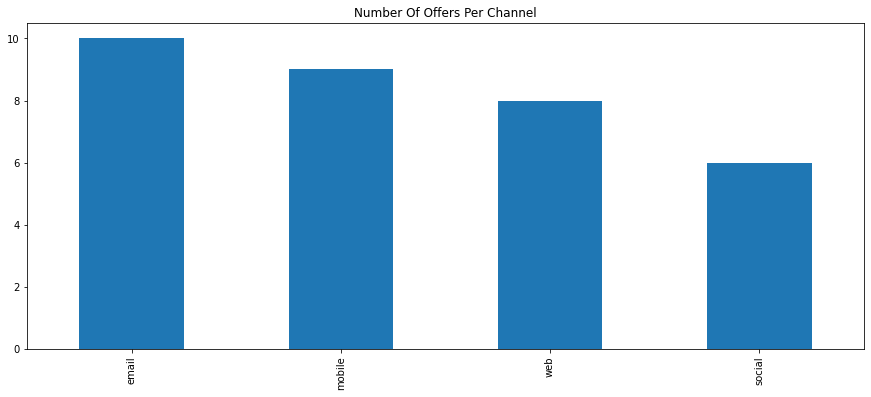

In [134]:
# Count channels
channels = portfolio.channels.explode().unique()
channel_counts = dict()
for channel in channels:
    channel_counts[channel] = portfolio.channels.str.contains(channel, regex=False).sum()
    
# Plot number of offers per channel
plt.title("Number Of Offers Per Channel")
pd.Series(channel_counts).sort_values(ascending=False).plot(kind='bar')
plt.show()

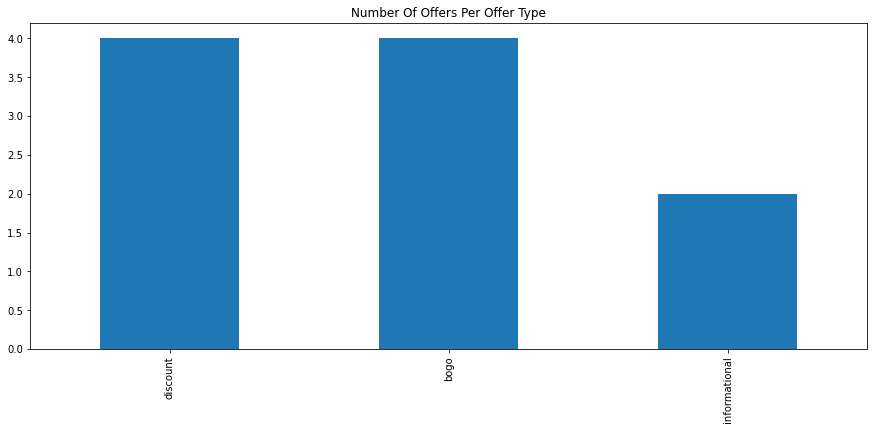

In [135]:
# Plot number of offers per offer type
plt.title("Number Of Offers Per Offer Type")
portfolio.offer_type.value_counts().plot(kind='bar')
plt.show()

## Customer

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [136]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [137]:
profile.shape

(17000, 5)

In [138]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


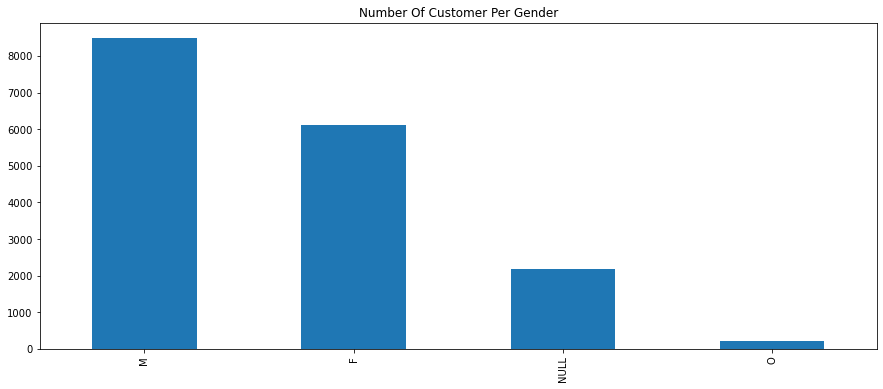

In [139]:
plt.title("Number Of Customer Per Gender")
profile.gender.fillna('NULL').value_counts().plot(kind='bar')
plt.show()

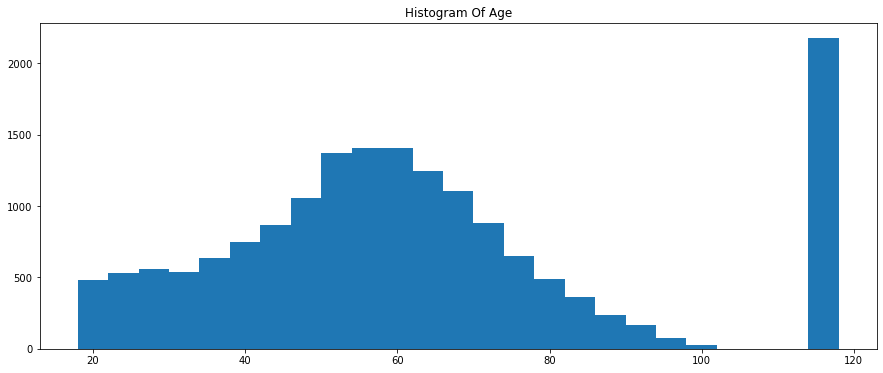

In [140]:
plt.title("Histogram Of Age")
profile.age.hist(bins=25, grid=False)
plt.show()

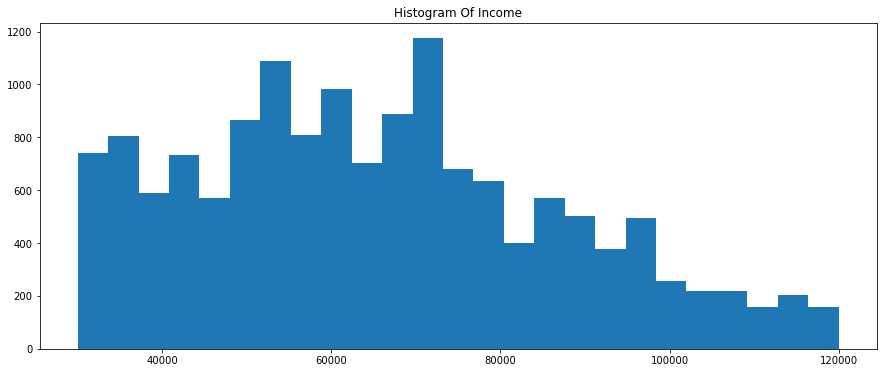

In [141]:
plt.title("Histogram Of Income")
profile.income.hist(bins=25, grid=False)
plt.show()

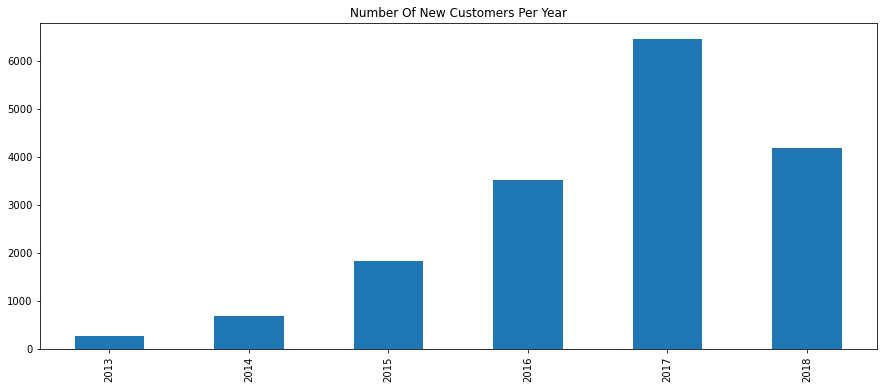

In [142]:
plt.title("Number Of New Customers Per Year")
pd.to_datetime(profile.became_member_on, format='%Y%m%d').dt.year.value_counts().sort_index().plot(kind='bar')
plt.show()

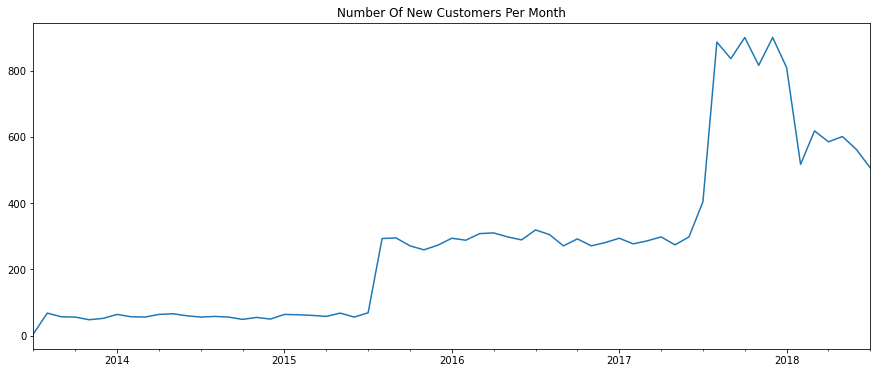

In [143]:
plt.title("Number Of New Customers Per Month")
pd.to_datetime(profile.became_member_on, format='%Y%m%d').value_counts().resample('1M').sum().sort_index().plot(kind='line')
plt.show()

## Transactions

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [144]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [145]:
transcript.shape

(306534, 4)

In [146]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


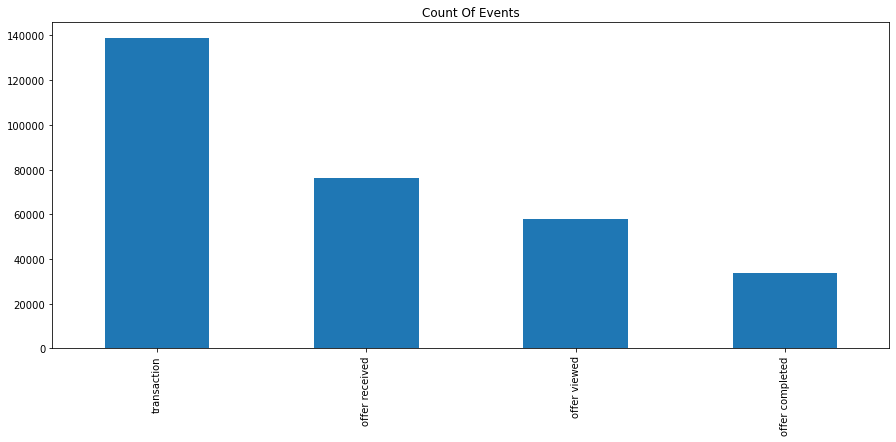

In [156]:
plt.title("Count Of Events")
transcript.event.value_counts().plot(kind='bar')
plt.show()

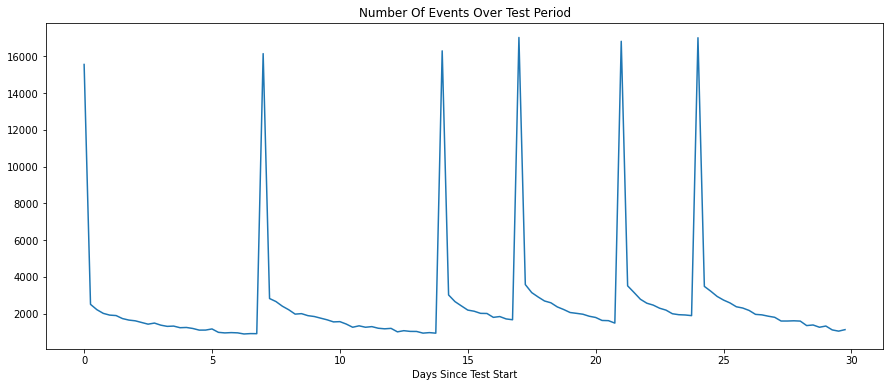

In [158]:
plt.title("Total Number Of Events Over Test Period")
(transcript.time/24).value_counts().sort_index().plot()
plt.xlabel("Days Since Test Start")
plt.show()

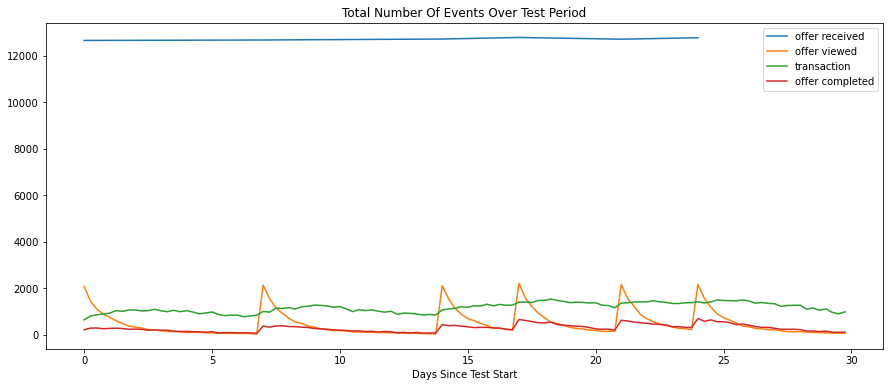

In [169]:
plt.title("Total Number Of Events Over Test Period")
for event in transcript.event.unique():
    (transcript[transcript.event==event].time/24).value_counts().sort_index().plot(label=event)
plt.xlabel("Days Since Test Start")
plt.legend()
plt.show()

In [177]:
transcript[transcript.person=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


# Data Processing

Attributes
* person
* offer
* ts
* viewed
* completed